### Import Libraries

In [24]:
# data
import pandas as pd
import numpy as np
import psycopg2


#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

### Read and Explain Dataset

In [50]:
# Define the connection parameters
postgress_config = {
    "database": "staging",
    "user": "postgres",
    "password": "Admin123",
    "host": "localhost",
    "port": "5432",
}

# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(**postgress_config)

# Define your SQL query
sql_query = """
    select gender,
        sector,
        date_of_birth,
        income,
        employment_status,
        years_of_employment,
        education_level,
        loan_amount,
        loan_amount / income                 as loan_to_income_ratio,
        interest_rate / loan_amount          as int_rate_to_loan_amt_ratio,
        interest_rate,
        status,
        loan_intent,
        credit_score,
        loan_term,
        loan_grade,
        repayment_method,
        collateral_value,
        cb_person_default_on_file,
        cb_preson_cred_hist_length,
        loan_purpose
    from staging.public.customers c
            join public.loans l on c.customer_id = l.customer_id;
"""

# Use pandas to execute the query and read the results into a DataFrame
df = pd.read_sql(sql_query, conn)

# Close the database connection
conn.close()

df.head()

,gender,sector,date_of_birth,income,employment_status,years_of_employment,education_level,loan_amount,loan_to_income_ratio,int_rate_to_loan_amt_ratio,...,status,loan_intent,credit_score,loan_term,loan_grade,repayment_method,collateral_value,cb_person_default_on_file,cb_preson_cred_hist_length,loan_purpose
0,Female,Government,1979-06-17,23799.82,Employed,14.0,None,NaN,NaN,NaN,...,0.0,Education,300.0,38.0,F,None,3595.0,Y,0.0,None
1,Female,Healthcare,1981-06-16,54295.48,None,6.0,Master's Degree,28697.0,0.528534,0.000075,...,1.0,Business,NaN,60.0,G,Monthly,16789.0,N,0.0,Equipment Purchase
2,Male,Healthcare,1986-06-15,46394.53,Unemployed,NaN,Doctorate,10156.0,0.218905,0.000610,...,0.0,Personal,415.0,21.0,E,Monthly,10087.0,N,0.0,Vacation
3,Female,Finance,1986-06-15,122286.09,Unemployed,16.0,Master's Degree,54435.0,0.445145,0.000220,...,None,Business,800.0,54.0,A,Monthly,NaN,N,1.0,Equipment Purchase
4,Male,Technology,1987-06-15,14437.77,Employed,0.0,Associate's Degree,7466.0,0.517116,0.000496,...,0.0,Mortgage,300.0,17.0,E,Bi-weekly,4381.0,N,3.0,Home Purchase


### Data cleaning

In [51]:
#Information on features 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   gender                      3167 non-null   object 
 1   sector                      3147 non-null   object 
 2   date_of_birth               3197 non-null   object 
 3   income                      3182 non-null   float64
 4   employment_status           3197 non-null   object 
 5   years_of_employment         3202 non-null   float64
 6   education_level             3173 non-null   object 
 7   loan_amount                 3157 non-null   float64
 8   loan_to_income_ratio        3013 non-null   float64
 9   int_rate_to_loan_amt_ratio  3015 non-null   float64
 10  interest_rate               3183 non-null   float64
 11  status                      3162 non-null   object 
 12  loan_intent                 3176 non-null   object 
 13  credit_score                3207 

from the the above output, we awared there are missing values in all columns. to handle missing values, I am simply going to drop the rows contain missing values.

In [52]:
#To remove the NA values
df = df.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(df))

The total number of data-points after removing the rows with missing values are: 1272


### Features engineering

Timestamp('2024-06-05 12:43:03.141455')

4      13505 days 12:45:41.498915
6       9125 days 12:45:41.498915
8      11315 days 12:45:41.498915
10     14235 days 12:45:41.498915
12      9125 days 12:45:41.498915
                  ...            
3325   13870 days 12:45:41.498915
3326   10585 days 12:45:41.498915
3327   11315 days 12:45:41.498915
3328   10585 days 12:45:41.498915
3332    8760 days 12:45:41.498915
Name: date_of_birth, Length: 1272, dtype: timedelta64[ns]

In [28]:
df.describe()

,age,income,years_of_employment,loan_amount,loan_to_income_ratio,int_rate_to_loan_amt_ratio,interest_rate,credit_score,loan_term,collateral_value,cb_preson_cred_hist_length
count,1272.000000,1272.000000,1272.000000,1272.000000,1272.000000,1272.000000,1272.000000,1272.000000,1272.000000,1272.000000,1272.000000
mean,30.952044,69877.403428,5.132862,33722.907233,0.480579,0.000402,7.038003,532.516509,36.380503,14527.256289,3.022799
std,7.871613,44471.519333,4.995556,23158.207934,0.101275,0.000492,2.916510,207.916856,14.183407,10951.268981,3.985254
min,18.000000,5672.200000,0.000000,1824.000000,0.203042,0.000023,2.020000,300.000000,12.000000,414.000000,0.000000
25%,25.000000,32410.350000,2.000000,15275.250000,0.408982,0.000130,4.520000,300.000000,24.750000,5797.500000,1.000000
50%,30.000000,61505.430000,4.000000,28083.500000,0.496213,0.000234,7.020000,497.500000,36.000000,11535.000000,2.000000
75%,35.000000,100309.270000,7.000000,48830.750000,0.566981,0.000455,9.560000,800.000000,49.000000,20875.000000,4.000000
max,64.000000,191324.380000,35.000000,113513.000000,0.623834,0.004886,12.000000,800.000000,60.000000,50000.000000,30.000000


Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

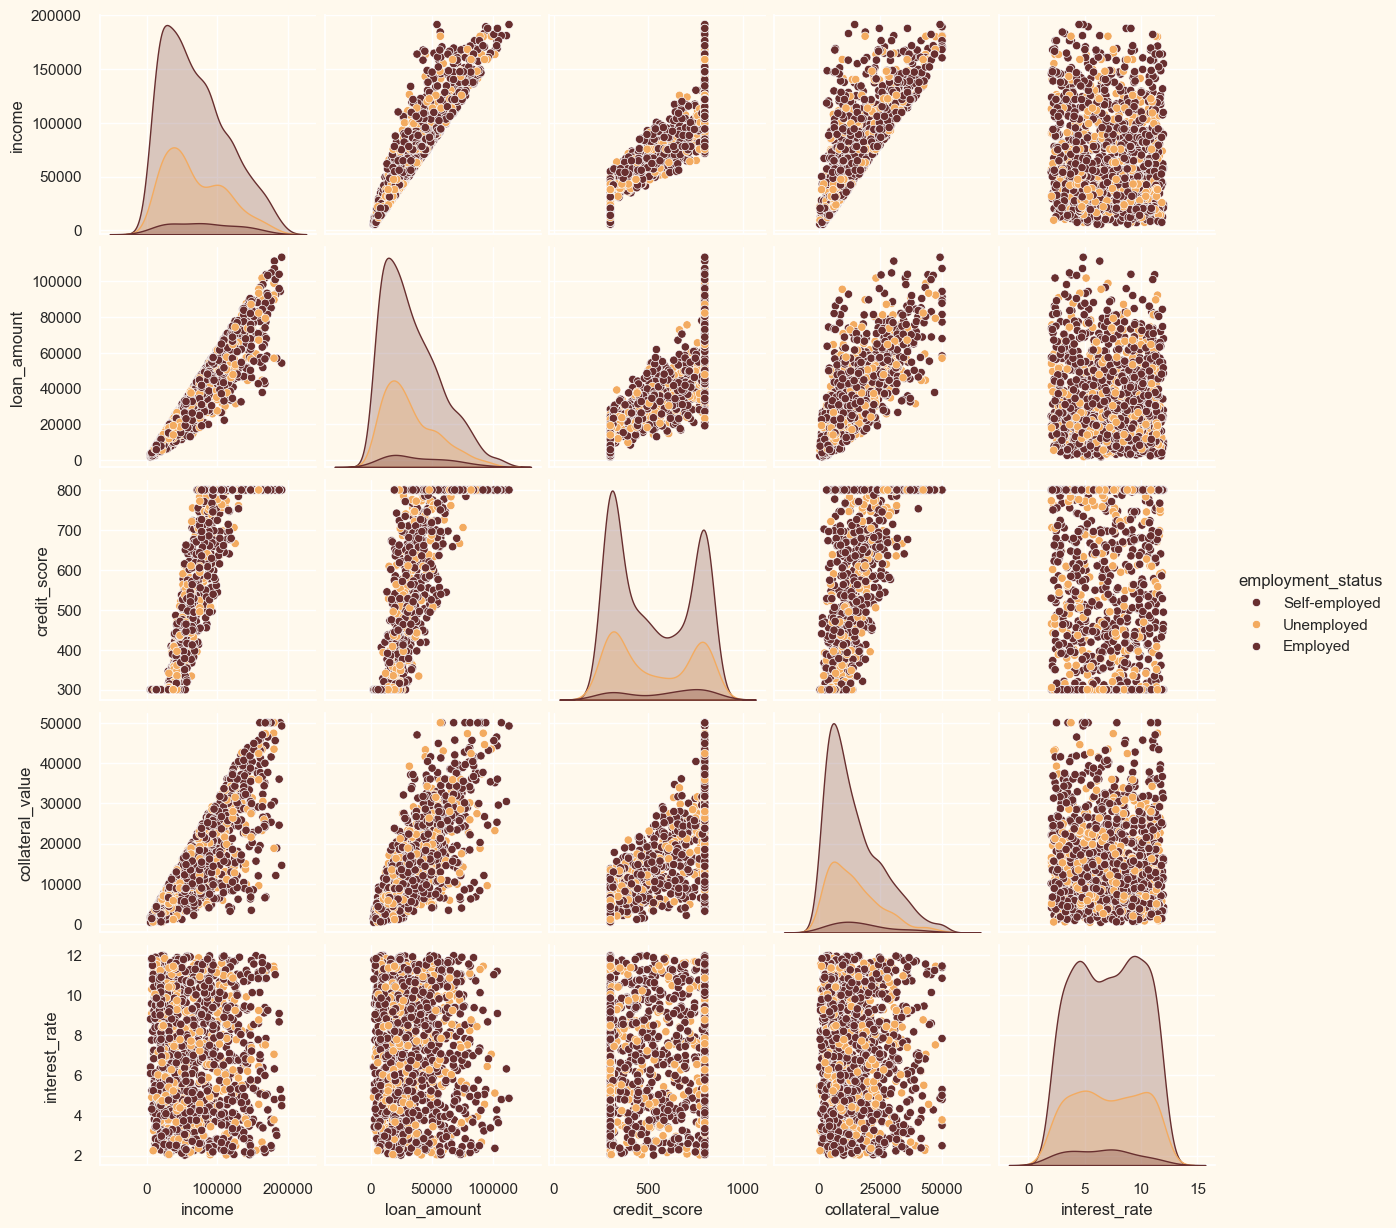

In [29]:
#To plot some selected features 
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "income", "loan_amount", "credit_score", "collateral_value", "interest_rate", "employment_status" ]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(df[To_Plot], hue= "employment_status",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1272 entries, 3 to 3330
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   gender                      1272 non-null   object 
 1   sector                      1272 non-null   object 
 2   age                         1272 non-null   float64
 3   income                      1272 non-null   float64
 4   employment_status           1272 non-null   object 
 5   years_of_employment         1272 non-null   float64
 6   education_level             1272 non-null   object 
 7   loan_amount                 1272 non-null   float64
 8   loan_to_income_ratio        1272 non-null   float64
 9   int_rate_to_loan_amt_ratio  1272 non-null   float64
 10  interest_rate               1272 non-null   float64
 11  status                      1272 non-null   object 
 12  loan_intent                 1272 non-null   object 
 13  credit_score                1272 non-n

In [31]:
from scipy import stats

threshold_z = 3
def remove_outlier(df: pd.DataFrame, threshold: int) -> pd.DataFrame:
    print("Original DataFrame Shape:", df.shape)
    outlier_indices = set()
    for col in df.columns:
        if df[col].dtype != 'object':
            z = np.abs(stats.zscore(df[col]))
            col_outliers = np.where(z > threshold)[0]
            outlier_indices.update(df.iloc[col_outliers].index)
    df = df.drop(list(outlier_indices))
    print("DataFrame Shape after Outlier Removal:", df.shape)

remove_outlier(df, threshold_z)
    

Original DataFrame Shape: (1272, 21)
DataFrame Shape after Outlier Removal: (1166, 21)


<Axes: >

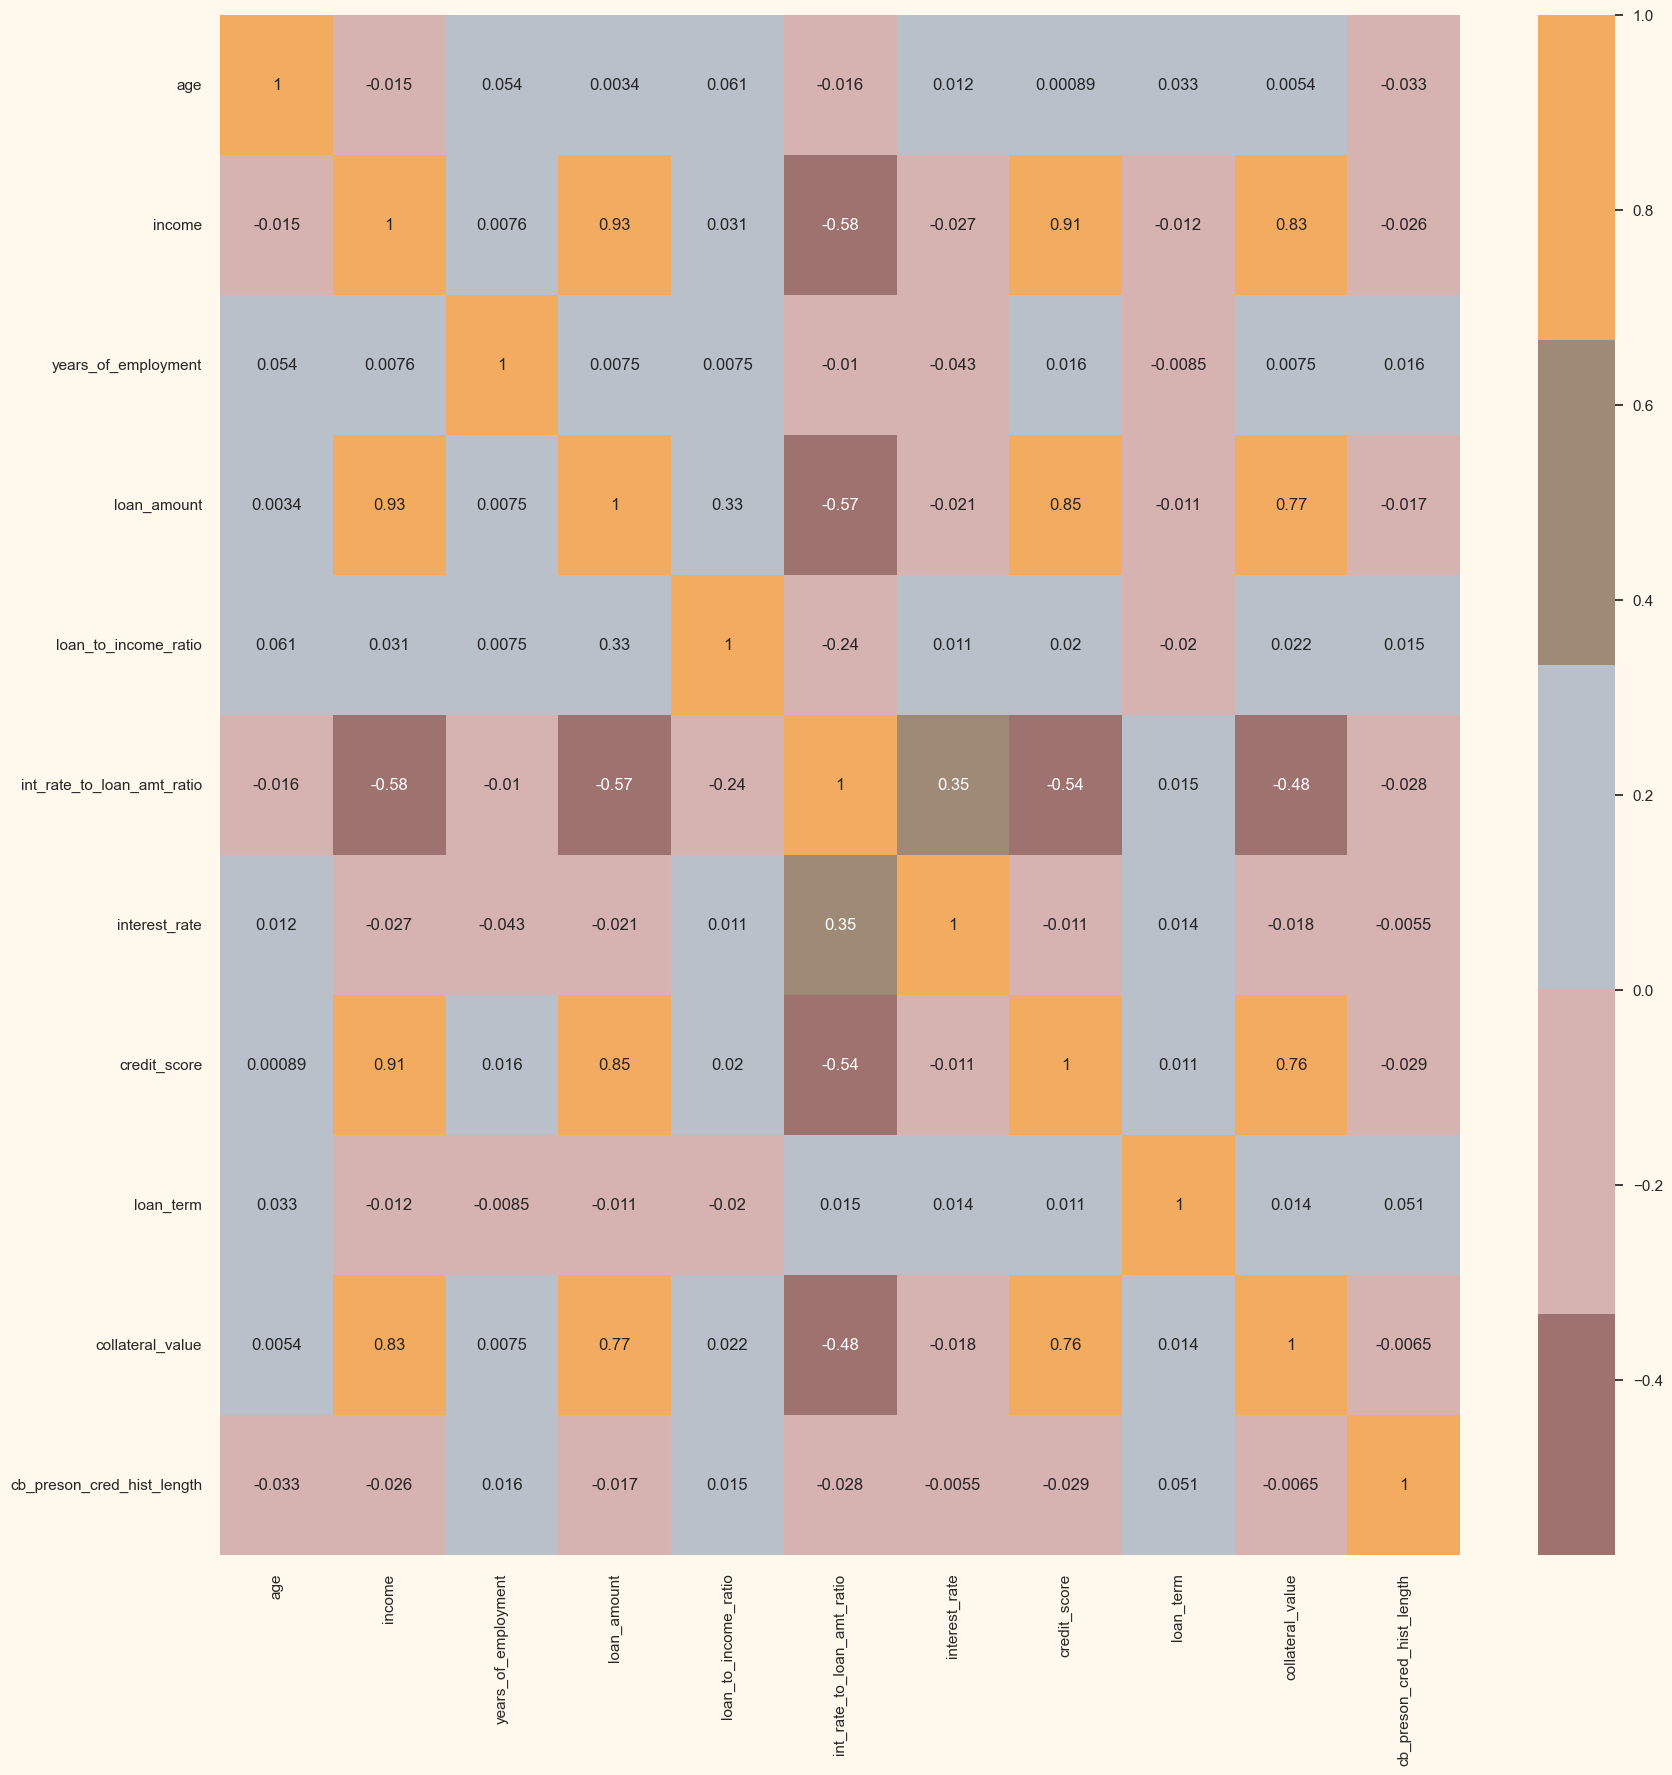

In [32]:
#correlation matrix
corrmat= df.corr(numeric_only=True)
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

### Data preprocessing

In [33]:
#Get list of categorical variables
s = (df.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['gender', 'sector', 'employment_status', 'education_level', 'status', 'loan_intent', 'loan_grade', 'repayment_method', 'cb_person_default_on_file', 'loan_purpose']


In [34]:
#Creating a copy of data
ds = df.drop(object_cols, axis=1).copy()
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [35]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,age,income,years_of_employment,loan_amount,loan_to_income_ratio,int_rate_to_loan_amt_ratio,interest_rate,credit_score,loan_term,collateral_value,cb_preson_cred_hist_length
0,0.641538,1.694138,-0.827633,1.353620,-0.320902,-0.561931,0.391717,1.286999,-1.508024,2.189990,-0.256747
1,0.641538,1.694138,-0.827633,1.885433,0.516683,-0.701377,-0.898002,1.286999,1.101685,-0.552414,-0.256747
2,0.133183,1.267637,0.173650,-0.093520,-2.277603,-0.657120,-1.560012,1.286999,-0.943762,2.254026,-0.758794
3,0.133183,1.267637,0.173650,1.132661,-0.056348,-0.499094,0.806759,1.286999,1.101685,1.467781,-0.758794
4,-1.646059,-0.323787,-0.427120,-0.781927,-1.965913,0.002200,-0.253143,-0.286364,-1.437491,0.254568,-0.507770


In [36]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,1272.0,-1.117206e-17,1.992244,-5.359500,-1.575969,0.179559,1.629284,5.804077
col2,1272.0,1.396507e-17,1.098683,-2.894963,-0.731071,-0.027923,0.758261,4.997508
col3,1272.0,-2.094760e-17,1.046858,-3.247009,-0.718570,0.022102,0.707607,3.366632


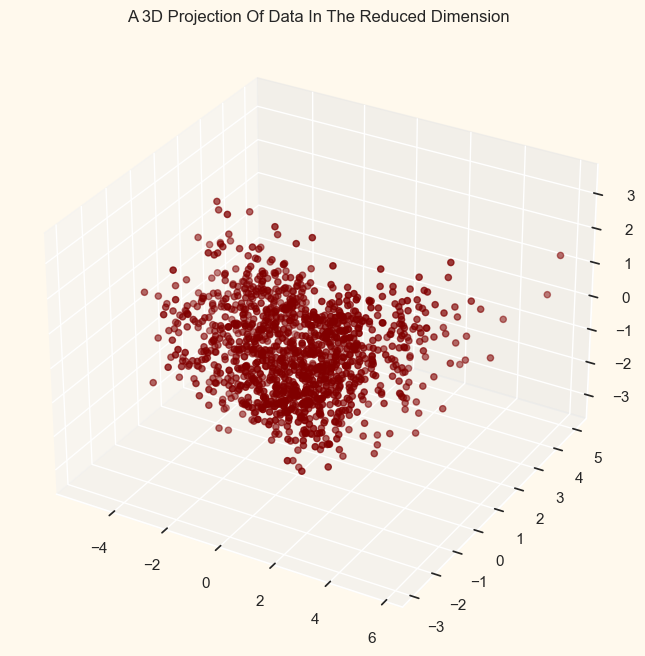

In [37]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

Elbow Method to determine the number of clusters to be formed:


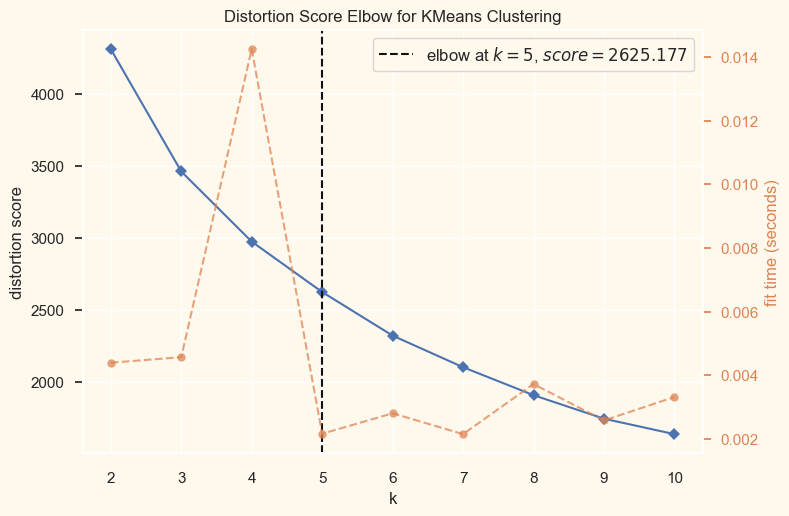

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [38]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [39]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=5)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= yhat_AC

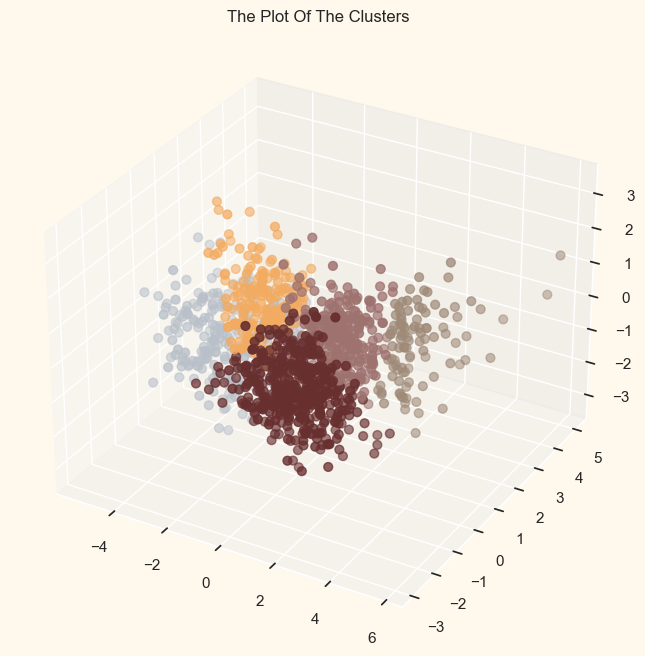

In [40]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

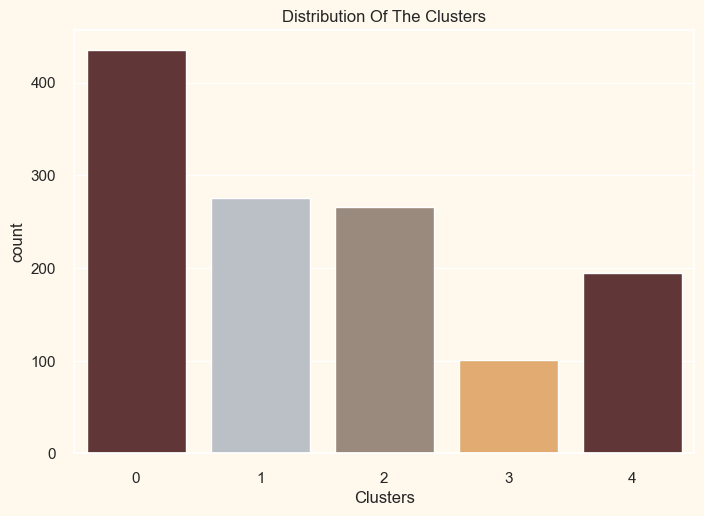

In [41]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=df["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

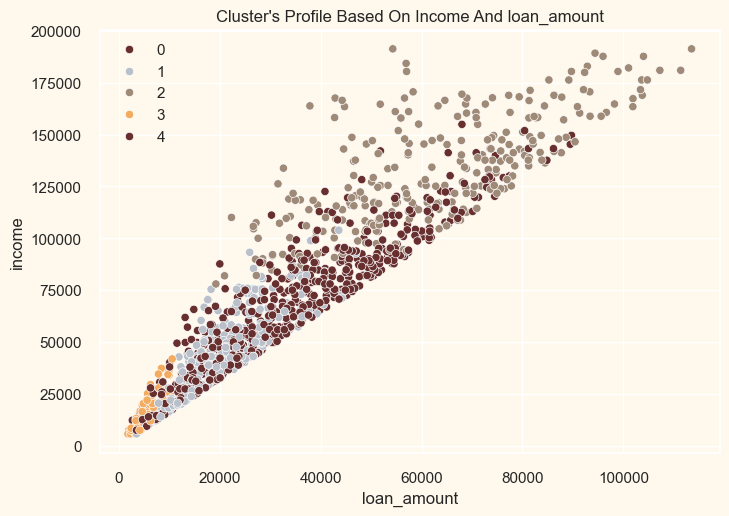

In [42]:
pl = sns.scatterplot(data = df,x=df["loan_amount"], y=df["income"],hue=df["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And loan_amount")
plt.legend()
plt.show()

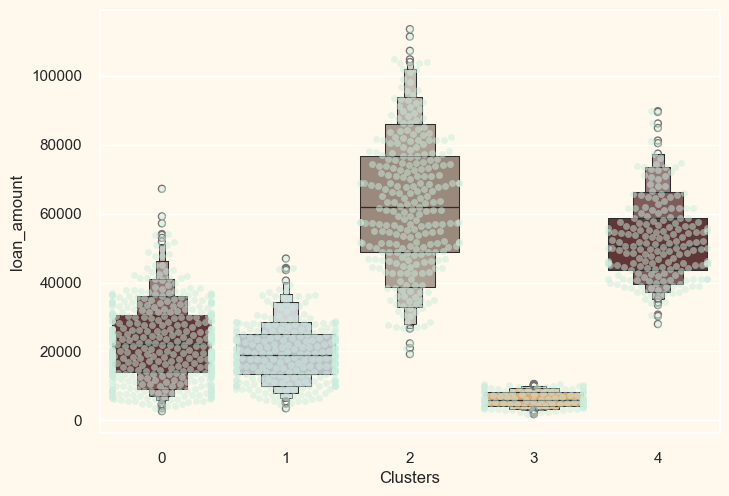

In [43]:
plt.figure()
pl=sns.swarmplot(x=df["Clusters"], y=df["loan_amount"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=df["Clusters"], y=df["loan_amount"], palette=pal)
plt.show()

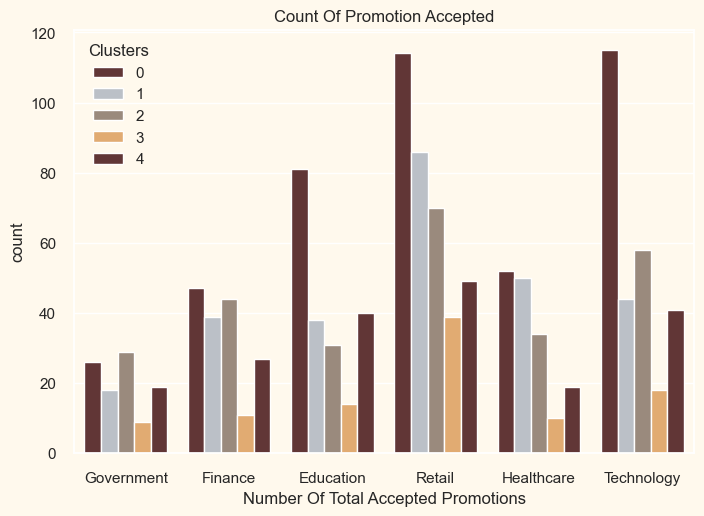

In [44]:
plt.figure()
pl = sns.countplot(x=df["sector"],hue=df["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

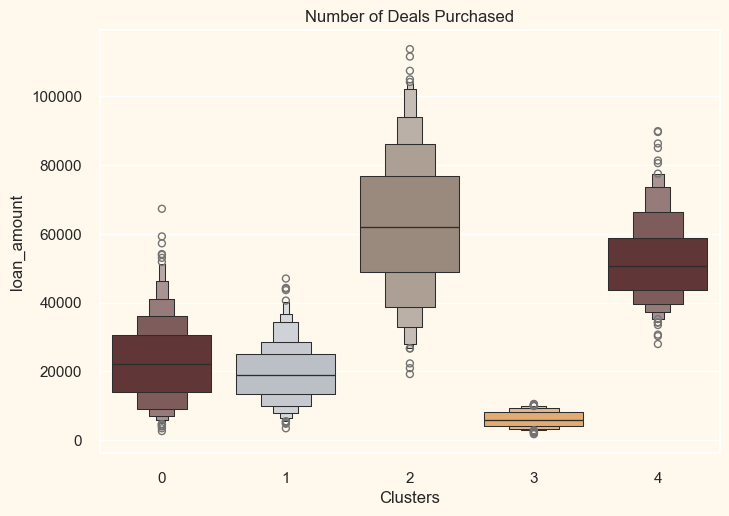

In [45]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=df["loan_amount"],x=df["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

<Figure size 800x550 with 0 Axes>

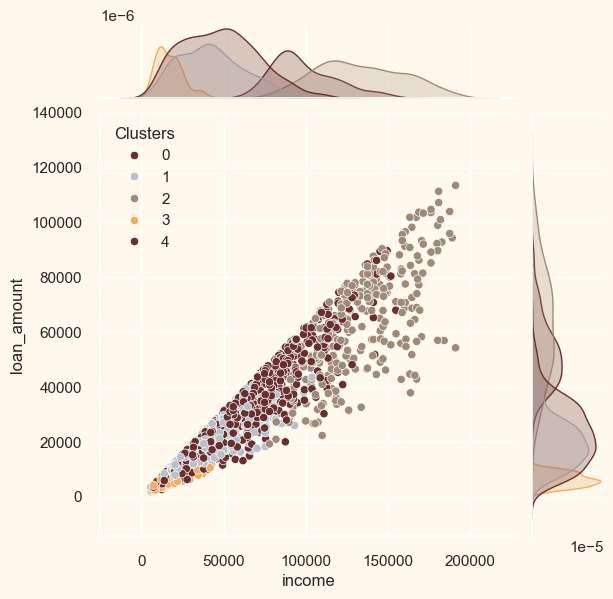

<Figure size 800x550 with 0 Axes>

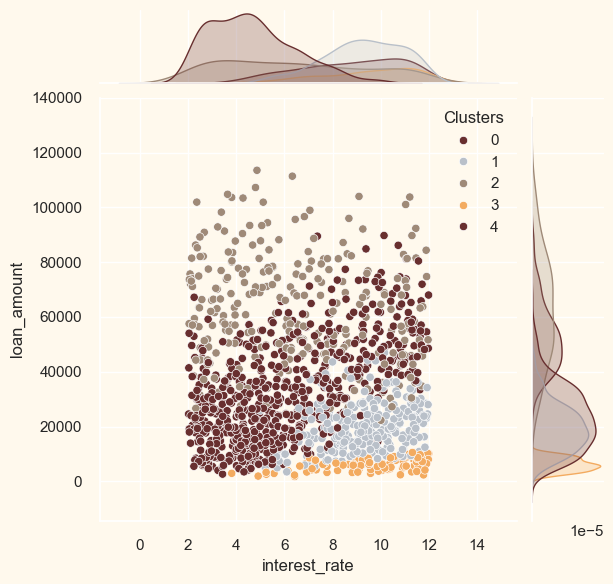

<Figure size 800x550 with 0 Axes>

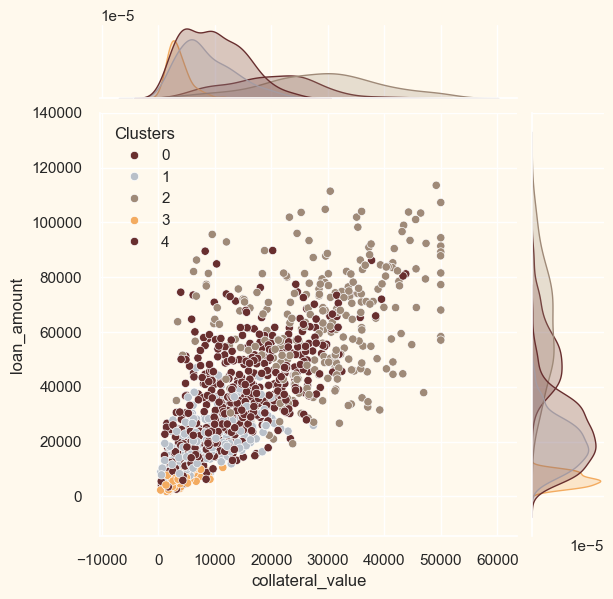

<Figure size 800x550 with 0 Axes>

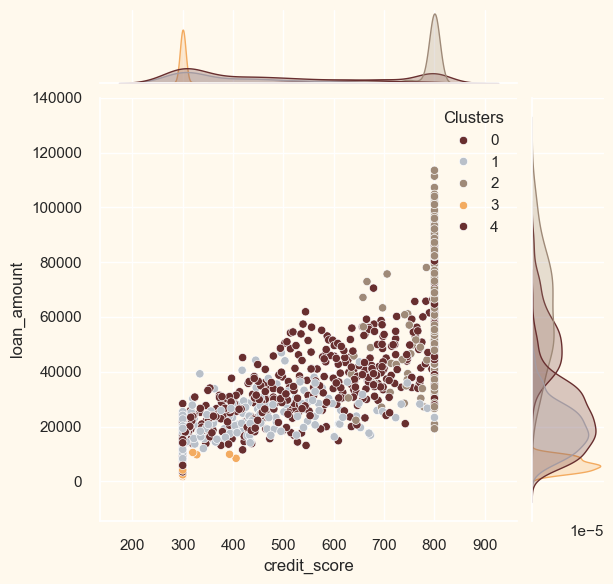

In [46]:
#for more details on the purchasing style 
Places =['income', 'interest_rate', 'collateral_value', 'credit_score'] 

for i in Places:
    plt.figure()
    sns.jointplot(x=df[i],y = df["loan_amount"],hue=df["Clusters"], palette= pal)
    plt.show()

In [80]:
class Solution(object):
    def merge(self, nums1, m, nums2, n):
        """
        :type nums1: List[int]
        :type m: int
        :type nums2: List[int]
        :type n: int
        :rtype: None Do not return anything, modify nums1 in-place instead.
        """
        nums1 = nums1[:m] + nums2[:n]
        nums1 = nums1.sort()

In [65]:
nums1 = [1,2,3,0,0,0]
m = 3
nums2 = [2,5,6]
n = 3

In [81]:
nums1

[1, 2, 3, 0, 0, 0]